In [ ]:
import pandas as pd
import re
import string
import nltk
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Ensure NLTK stopwords are downloaded
nltk.download('stopwords')

class DatasetLoader:
    def __init__(self, file_path):
        self.file_path = file_path
        self.df = pd.read_csv(self.file_path)
        self.tokenizer = None
        self.label_encoder = None

    def clean_text(self, text):
        text = text.lower()  # Convert to lowercase
        text = re.sub(f"[{string.punctuation}]", "", text)  # Remove punctuation
        text = re.sub(r"\d+", "", text)  # Remove numbers
        text = re.sub(r"([?.!,¿])", r" ", text)
        text = re.sub(r'\s+', ' ', text).strip()
        text = re.sub(r'@\w+', '', text)  # Remove mentions
        stop_words = set(stopwords.words('english'))
        text = ' '.join([word for word in text.split() if word not in stop_words])
        return text

    def preprocess_data(self):
        self.df['cleaned_sentence'] = self.df['sentence'].astype(str).apply(self.clean_text)
        X = self.df['cleaned_sentence'].values
        y = self.df['emotion'].values

        # Encode labels
        self.label_encoder = LabelEncoder()
        y = self.label_encoder.fit_transform(y)

        # Tokenization and Padding
        max_words = 1000  # Vocabulary size
        max_len = 100  # Max length of a comment
        self.tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
        self.tokenizer.fit_on_texts(X)
        X_seq = self.tokenizer.texts_to_sequences(X)
        X_padded = pad_sequences(X_seq, maxlen=max_len, padding='post', truncating='post')

        return X_padded, y

    def save_preprocessing_objects(self, tokenizer_path, label_encoder_path):
        with open(tokenizer_path, 'wb') as f:
            pickle.dump(self.tokenizer, f)
        with open(label_encoder_path, 'wb') as f:
            pickle.dump(self.label_encoder, f)

class EmotionCNNModel:
    def __init__(self, max_words=1000, max_len=100):
        self.max_words = max_words
        self.max_len = max_len
        self.model = None

    def build_model(self, num_classes, learning_rate=0.001, filters=128, kernel_size=5, dense_units=64, dropout_rate=0.5):
        self.model = Sequential([
            Embedding(self.max_words, 128, input_length=self.max_len),
            Conv1D(filters, kernel_size, activation='relu'),
            GlobalMaxPooling1D(),
            Dense(dense_units, activation='relu'),
            Dropout(dropout_rate),
            Dense(num_classes, activation='softmax')
        ])
        optimizer = Adam(learning_rate=learning_rate)
        self.model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return self.model

    def train_model(self, X_train, y_train, X_test, y_test, epochs=10, batch_size=32):
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
        history = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])
        return history

    def save_model(self, model_path):
        self.model.save(model_path)

    @staticmethod
    def load_trained_model(model_path):
        return load_model(model_path)

class EmotionPredictor:
    def __init__(self, model_path, tokenizer_path, label_encoder_path, max_len=100):
        self.model = load_model(model_path)
        self.max_len = max_len
        with open(tokenizer_path, 'rb') as f:
            self.tokenizer = pickle.load(f)
        with open(label_encoder_path, 'rb') as f:
            self.label_encoder = pickle.load(f)

    def predict_emotion(self, comment_text):
        seq = self.tokenizer.texts_to_sequences([comment_text])
        padded = pad_sequences(seq, maxlen=self.max_len, padding='post', truncating='post')
        prediction = self.model.predict(padded)
        emotion = self.label_encoder.inverse_transform([np.argmax(prediction)])
        return emotion[0]

if __name__ == "__main__":
    file_path = 'combined_emotion.csv'
    tokenizer_path = 'tokenizer.pkl'
    label_encoder_path = 'label_encoder.pkl'
    model_path = 'emotion_cnn_model.h5'

    dataset = DatasetLoader(file_path)
    # X, y = dataset.preprocess_data()
    # dataset.save_preprocessing_objects(tokenizer_path, label_encoder_path)
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # emotion_cnn = EmotionCNNModel()
    # model = emotion_cnn.build_model(num_classes=len(set(y)))
    # history = emotion_cnn.train_model(X_train, y_train, X_test, y_test)
    # emotion_cnn.save_model(model_path)

    # plt.plot(history.history['accuracy'], label='Before Tuning')
    # plt.plot(history.history['val_accuracy'], label='After Tuning')
    # plt.xlabel('Epochs')
    # plt.ylabel('Accuracy')
    # plt.legend()
    # plt.title('Model Accuracy Comparison')
    # plt.show()

    predictor = EmotionPredictor(model_path, tokenizer_path, label_encoder_path)
    user_comment ="how are you doing"
    cleaned_comment = dataset.clean_text(user_comment)
    predicted_emotion = predictor.predict_emotion(cleaned_comment)
    print(f"Predicted Emotion using CNN: {predicted_emotion}")




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\charu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Predicted Emotion using CNN: anger


2643/2643 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step

Classification Report:

              precision    recall  f1-score   support

       anger       0.89      0.87      0.88     11810
        fear       0.97      0.76      0.85      9952
         joy       0.88      0.93      0.90     28781
        love       0.78      0.88      0.83      6929
         sad       0.95      0.93      0.94     24036
     suprise       0.76      0.83      0.80      3042

    accuracy                           0.89     84550
   macro avg       0.87      0.87      0.87     84550
weighted avg       0.90      0.89      0.89     84550



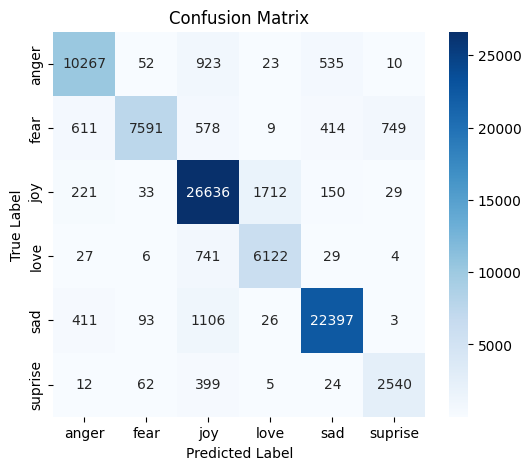

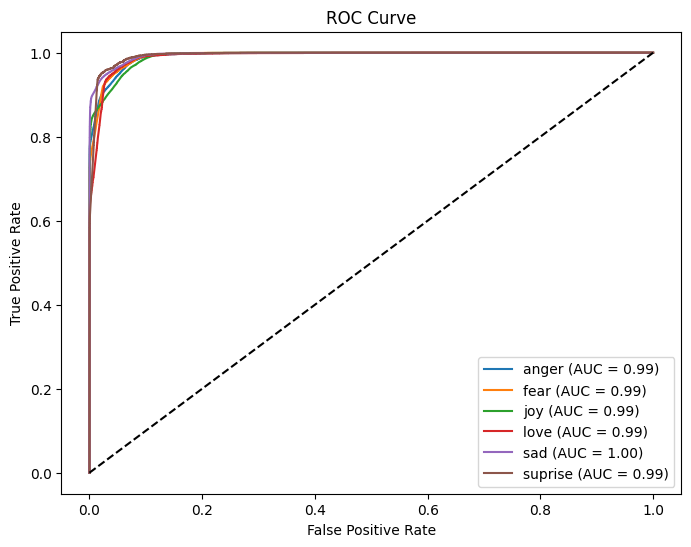

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

# Get model predictions on test data
y_pred_proba = predictor.model.predict(X_test)  # Predicted probabilities
y_pred = np.argmax(y_pred_proba, axis=1)  # Convert probabilities to class indices

# **1. Classification Report (Precision, Recall, F1-Score)**
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=predictor.label_encoder.classes_))

# **2. Confusion Matrix**
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=predictor.label_encoder.classes_, yticklabels=predictor.label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# **3. ROC Curve and AUC Score**
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(predictor.label_encoder.classes_):
    fpr, tpr, _ = roc_curve(y_test == i, y_pred_proba[:, i])  # Compute FPR, TPR
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")

# Plot random chance line
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [1]:
user_comment = "can you be a little patient"
cleaned_comment = dataset.clean_text(user_comment)
predicted_emotion = predictor.predict_emotion(cleaned_comment)
print(f"Predicted Emotion using CNN: {predicted_emotion}")


NameError: name 'dataset' is not defined